In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# Collab
#%pip install pygam
#%pip install optuna

In [2]:
# %% load packages
import locale
import sys
import os
import time
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import optuna
import requests
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import random
from sqlalchemy import create_engine,inspect
from pathlib import Path
import urllib.parse
import pyarrow
from calendar import day_abbr
import calendar
from typing import Tuple, Union, Dict, List
from concurrent.futures import ThreadPoolExecutor, as_completed
from pygam import LinearGAM
from datetime import datetime

/opt/anaconda3/envs/dl-energy-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Collab
#!git clone https://github.com/aamaguay/DLiE_forecast.git
#%cd DLiE_forecast
#!pip install -e .

import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
from srs.utils.tutor_utils import prepare_dataset_tensor, forecasting_study,\
  plot_daily_profile,plot_hour_comparison, build_multiwindow_experts, tune_ewa_eta, \
  ewa_aggregate_forecasts, compute_error_table, tune_expert_window, \
  run_expert_window_test, build_regression_matrix, prepare_train_test_tensors, \
  DST_trafo, prepare_dataset_tensor_modified

from srs.utils.our_utils import run_forecast_step
from srs.collect_data.setup import setup_seed, get_device
from srs.collect_data.entsoe_data import create_entsoe_engine, get_tables, get_spec, \
  get_market_divisions,get_map_codes,get_map_codes_starting_with, get_resolution_codes, \
    prepare_generation, prepare_load,prepare_price, prepare_unavailability, \
    prepare_filling_rate_hydro, prepare_physical_flow, prepare_installed_capacity
from srs.collect_data.datastream_data import create_datastream_engine, get_tables, \
  prepare_datastream
from srs.collect_data.dwd_mosmix_data import fetch_region_weather, prepare_weather
from srs.collect_data.merge_data import merge_datasets, build_training_dataset
from srs.models.mlp import SimpleMLP, train_mlp, build_mlp_rolling_forecasts, \
  tune_mlp_hyperparameters, DeepMLP, build_mlp_rolling_forecasts_weighted_loss


In [ ]:
'''
  training interval:
  2019 - 365 days
  2020 - 366 days
  2021 - 365 days
  2022 - 366 days
  
  testing interval:
  2023 - 365 days
  2024 - 366 days
  
  
The reason why I have metnioned lightgbm and GAM before is that I have, as one of the alternative methodologies, to get preliminary predictions from gam,lightbgm or any other models, use these predictions as a input for a input layer to get final predictions from MLP.
That is why I need to be consistent for now with 
'''

### 1. SimpleMLP - rolling window and without Optuna

In [ ]:
# global constants to all zones
INIT_DATE_EXPERIMENTS = '2019-01-01'
INIT_TEST_DATE        = '2023-01-01'
FINAL_DATE_EXPERIMENTS= '2024-12-31'

# hyperparameters
WINDOW_DAYS   = 730                 
HIDDEN_DIM    = 50                  
LEARNING_RATE = 1e-3
WEIGHT_DECAY  = 1e-3
EPOCHS        = 60
BATCH_SIZE    = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

repo_root  = Path.cwd().parents[1]
mapcodes   = ["NO1", "NO2", "NO3", "NO4", "NO5"]
zone_data  = {}          

for code in mapcodes:
    csv_path = repo_root / "data" / f"data_{code}.csv"
    df_raw   = pd.read_csv(csv_path, parse_dates=["time_utc"])

    data_t, train_t, train_dates, price_t = prepare_dataset_tensor_modified(
        csv_path,
        tz      = "CET",
        seed    = 42,
        test_days = (pd.Timestamp(FINAL_DATE_EXPERIMENTS)
                     - pd.Timestamp(INIT_TEST_DATE)).days + 1,
        dtype   = torch.float64,
    )

    idx = pd.DatetimeIndex(sorted(train_dates))
    start_i = idx.get_loc(pd.Timestamp(INIT_DATE_EXPERIMENTS))
    end_i   = idx.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
    data_t  = data_t[start_i:end_i+1]             
    dates_t = pd.Series(train_dates[start_i:end_i+1])

    zone_data[code] = dict(
        df        = df_raw,
        tensor    = data_t,
        dates     = dates_t,
        price_t   = price_t[start_i:end_i+1],
    )

# rolling-window MLP per zone
rmse_mlp_by_zone   = {}
preds_mlp_by_zone  = {}

for code in mapcodes:
    print(f"\n==== Zone {code} ====")

    reg_data = build_regression_matrix(
        dat_eval = zone_data[code]["tensor"].cpu().numpy(),
        days_eval= pd.to_datetime(zone_data[code]["dates"]),
        reg_names= zone_data[code]["df"].columns[1:],   
    )
    reg_df   = reg_data["regmat"].dropna().reset_index(drop=True)
    dep_idx  = reg_data["dep_indices"]

    all_dates = pd.DatetimeIndex(sorted(zone_data[code]["dates"]\
                                        .iloc[len(zone_data[code]["dates"])
                                             - len(reg_df):]))
    test_start_row = all_dates.get_loc(pd.Timestamp(INIT_TEST_DATE))
    test_end_row   = all_dates.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
    horizon        = test_end_row - test_start_row + 1      

    preds, trues = build_mlp_rolling_forecasts(
        regmat_df   = reg_df.astype("float32"),
        dep_indices = dep_idx,
        window      = WINDOW_DAYS,
        horizon     = horizon,
        start_row   = test_start_row,
        hidden_dim  = HIDDEN_DIM,
        lr          = LEARNING_RATE,
        weight_decay= WEIGHT_DECAY,
        batch_size  = BATCH_SIZE,
        epochs      = EPOCHS,
        device      = device,
    )

    rmse = torch.sqrt(((preds - trues) ** 2).mean()).item()
    rmse_mlp_by_zone[code]  = rmse
    preds_mlp_by_zone[code] = preds                   

    print(f"RMSE 2023-24: {rmse:7.3f}")

print("\n===== Rolling-MLP RMSE ( NOK / MWh ) =====")
for z, r in rmse_mlp_by_zone.items():
    print(f"{z}:  {r:7.3f}")


In [ ]:
# -------------------------------------------------------------
# 3)  Append to forecast_all and compute error table
mlp_chan  = preds_mlp.unsqueeze(2)            # (N,24,1)
forecast_all = torch.cat([forecast_all, mlp_chan], dim=2)
model_names  = model_names + ["MLP"]

err_table_with_mlp = compute_error_table(forecast_all, model_names)
print(err_table_with_mlp)


Rolling MLP RMSE 2023-24: \
NO1 21.057 \
NO2 24.377 \
NO3 15.700 \
NO4 11.912 \
NO5 17.403

### 2. Deep MLP – Rolling‑window

| **Component**          | **Sub-Component**         | **Details**                                                                                                                                                                                                           |
| ---------------------- | ------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Features**           | **Per-hour block (×24)**  | • `Price_s{h}`: current-day spot price (target)<br> • `Price_lag_{1,2,7}_s{h}`: lags 1,2,7 days<br> • `{Load,Solar,WindOn,WindOff}_DA_lag_0_s{h}`: day-ahead quantities (no lag)<br> **⇒ 8 cols/hour ⇒ 192 total**    |
|                        | **Global block (shared)** | • `WD_{1–7}`: weekday dummies Mon…Sun (7 cols)<br> • `{Coal,NGas,Oil,EUA}_lag_2`: fuel & EUA prices, 2-day lag (4 cols)<br> **⇒ 11 total**                                                                            |
|                        | **Total feature width**   | **192 + 11 = 203**                                                                                                                                                                                                    |
| **Model**              | **DeepMLP**               | Input: 203 ➔ Linear(203→128) ➔ LeakyReLU ➔ Dropout(0.10)<br> ➔ Linear(128→128) ➔ LeakyReLU ➔ Dropout(0.10)<br> ➔ Linear(128→24)  <br>Depth=2 hidden layers<br>Params ≈ (203×128+128)+(128×128+128)+(128×24+24) ≃ 54 k |
| **Training (per day)** | **Pre-processing**        | Standardise X & y with rolling 730-day window (z-score)                                                                                                                                                               |
|                        | **Optimizer**             | Adam(lr=1e-3, weight\_decay=1e-3)                                                                                                                                                                                     |
|                        | **Batch size**            | 64                                                                                                                                                                                                                    |
|                        | **Epochs**                | 60                                                                                                                                                                                                                    |
|                        | **Loss**                  | MSE on the 24-dim output vector                                                                                                                                                                                       |
|                        | **Prediction**            | Forecast next day (predictions per 24h)                                                                                                                                                                                |


In [ ]:
# global constants to all zones
INIT_DATE_EXPERIMENTS = '2019-01-01'
INIT_TEST_DATE        = '2024-01-01'
FINAL_DATE_EXPERIMENTS= '2024-12-31'

# hyperparameters
WINDOW_DAYS   = 730                 
HIDDEN_DIM    = 128 # initial - 50                  
LEARNING_RATE = 1e-3
WEIGHT_DECAY  = 1e-3
EPOCHS        = 60
BATCH_SIZE    = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#%cd /content/DLiE_forecast <- Collab
#repo_root  = Path.cwd().resolve() <-Collab
repo_root  = Path.cwd().parents[1]
mapcodes   = ["NO1", "NO2", "NO3", "NO4", "NO5"]
zone_data  = {}          

for code in mapcodes:
    csv_path = repo_root / "data" / f"data_{code}.csv"
    df_raw   = pd.read_csv(csv_path, parse_dates=["time_utc"])

    data_t, train_t, train_dates, price_t = prepare_dataset_tensor_modified(
        csv_path,
        tz      = "CET",
        seed    = 42,
        test_days = (pd.Timestamp(FINAL_DATE_EXPERIMENTS)
                     - pd.Timestamp(INIT_TEST_DATE)).days + 1,
        dtype   = torch.float64,
    )

    idx = pd.DatetimeIndex(sorted(train_dates))
    start_i = idx.get_loc(pd.Timestamp(INIT_DATE_EXPERIMENTS))
    end_i   = idx.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
    data_t  = data_t[start_i:end_i+1]             
    dates_t = pd.Series(train_dates[start_i:end_i+1])

    zone_data[code] = dict(
        df        = df_raw,
        tensor    = data_t,
        dates     = dates_t,
        price_t   = price_t[start_i:end_i+1],
    )

# rolling-window MLP per zone
rmse_dmlp_by_zone   = {}
preds_dmlp_by_zone  = {}

for code in mapcodes:
    print(f"\n==== Zone {code} ====")

    reg_data = build_regression_matrix(
        dat_eval = zone_data[code]["tensor"].cpu().numpy(),
        days_eval= pd.to_datetime(zone_data[code]["dates"]),
        reg_names= zone_data[code]["df"].columns[1:],   
    )
    reg_df   = reg_data["regmat"].dropna().reset_index(drop=True)
    dep_idx  = reg_data["dep_indices"]

    all_dates = pd.DatetimeIndex(sorted(zone_data[code]["dates"]\
                                        .iloc[len(zone_data[code]["dates"])
                                             - len(reg_df):]))
    test_start_row = all_dates.get_loc(pd.Timestamp(INIT_TEST_DATE))
    test_end_row   = all_dates.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
    horizon        = test_end_row - test_start_row + 1      

    preds, trues = build_mlp_rolling_forecasts(
        regmat_df   = reg_df.astype("float32"),
        dep_indices = dep_idx,
        window      = WINDOW_DAYS,
        horizon     = horizon,
        start_row   = test_start_row,
        hidden_dim  = HIDDEN_DIM,
        lr          = LEARNING_RATE,
        weight_decay= WEIGHT_DECAY,
        batch_size  = BATCH_SIZE,
        epochs      = EPOCHS,
        device      = device,
    )

    rmse_dmlp = torch.sqrt(((preds - trues) ** 2).mean()).item()
    rmse_dmlp_by_zone[code]  = rmse_dmlp
    preds_dmlp_by_zone[code] = preds                   

    print(f"RMSE 2023-24: {rmse_dmlp:7.3f}")

print("\n Rolling-MLP RMSE")
for z, r in rmse_dmlp_by_zone.items():
    print(f"{z}:  {r:7.3f}")


Rolling-MLP RMSE \
NO1:   20.866 \
NO2:   27.100 \
NO3:   13.934 \
NO4:    8.130 \
NO5:   16.446

### 2.1. same as above but traininng interval: 2019.01.01 - 2022.12.31

In [ ]:
# global constants to all zones
INIT_DATE_EXPERIMENTS = '2019-01-01'
INIT_TEST_DATE        = '2023-01-01'
FINAL_DATE_EXPERIMENTS= '2024-12-31'

# hyperparameters
WINDOW_DAYS   = 730                 
HIDDEN_DIM    = 128 # initial - 50                  
LEARNING_RATE = 1e-3
WEIGHT_DECAY  = 1e-3
EPOCHS        = 60
BATCH_SIZE    = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#%cd /content/DLiE_forecast <- Collab
#repo_root  = Path.cwd().resolve() <-Collab
repo_root  = Path.cwd().parents[1]
mapcodes   = ["NO1", "NO2", "NO3", "NO4", "NO5"]
zone_data  = {}          

for code in mapcodes:
    csv_path = repo_root / "data" / f"data_{code}.csv"
    df_raw   = pd.read_csv(csv_path, parse_dates=["time_utc"])

    data_t, train_t, train_dates, price_t = prepare_dataset_tensor_modified(
        csv_path,
        tz      = "CET",
        seed    = 42,
        test_days = (pd.Timestamp(FINAL_DATE_EXPERIMENTS)
                     - pd.Timestamp(INIT_TEST_DATE)).days + 1,
        dtype   = torch.float64,
    )

    idx = pd.DatetimeIndex(sorted(train_dates))
    start_i = idx.get_loc(pd.Timestamp(INIT_DATE_EXPERIMENTS))
    end_i   = idx.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
    data_t  = data_t[start_i:end_i+1]             
    dates_t = pd.Series(train_dates[start_i:end_i+1])

    zone_data[code] = dict(
        df        = df_raw,
        tensor    = data_t,
        dates     = dates_t,
        price_t   = price_t[start_i:end_i+1],
    )

# rolling-window MLP per zone
rmse_dmlp_by_zone   = {}
preds_dmlp_by_zone  = {}

for code in mapcodes:
    print(f"\n==== Zone {code} ====")

    reg_data = build_regression_matrix(
        dat_eval = zone_data[code]["tensor"].cpu().numpy(),
        days_eval= pd.to_datetime(zone_data[code]["dates"]),
        reg_names= zone_data[code]["df"].columns[1:],   
    )
    reg_df   = reg_data["regmat"].dropna().reset_index(drop=True)
    dep_idx  = reg_data["dep_indices"]

    all_dates = pd.DatetimeIndex(sorted(zone_data[code]["dates"]\
                                        .iloc[len(zone_data[code]["dates"])
                                             - len(reg_df):]))
    test_start_row = all_dates.get_loc(pd.Timestamp(INIT_TEST_DATE))
    test_end_row   = all_dates.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
    horizon        = test_end_row - test_start_row + 1      

    preds, trues = build_mlp_rolling_forecasts(
        regmat_df   = reg_df.astype("float32"),
        dep_indices = dep_idx,
        window      = WINDOW_DAYS,
        horizon     = horizon,
        start_row   = test_start_row,
        hidden_dim  = HIDDEN_DIM,
        lr          = LEARNING_RATE,
        weight_decay= WEIGHT_DECAY,
        batch_size  = BATCH_SIZE,
        epochs      = EPOCHS,
        device      = device,
    )

    rmse_dmlp = torch.sqrt(((preds - trues) ** 2).mean()).item()
    rmse_dmlp_by_zone[code]  = rmse_dmlp
    preds_dmlp_by_zone[code] = preds                   

    print(f"RMSE 2023-24: {rmse_dmlp:7.3f}")

print("\n Rolling-MLP RMSE")
for z, r in rmse_dmlp_by_zone.items():
    print(f"{z}:  {r:7.3f}")


Rolling-MLP RMSE \
NO1:   21.212 \
NO2:   26.185 \
NO3:   15.629 \
NO4:   11.252 \
NO5:   17.424

### 2.2. same as above but weight_decay = 0


==== Zone NO1 ====
Zone | Train start | Train end | Train mean | Test start | Test end | Test mean
NO1 | 30.705 | 12.010 | 26.435 | 19.159 | 10.494 | 16.173

==== Zone NO2 ====
Zone | Train start | Train end | Train mean | Test start | Test end | Test mean
NO1 | 30.705 | 12.010 | 26.435 | 19.159 | 10.494 | 16.173
NO2 | 29.911 | 12.863 | 28.034 | 15.587 | 18.366 | 17.465

==== Zone NO3 ====
Zone | Train start | Train end | Train mean | Test start | Test end | Test mean
NO1 | 30.705 | 12.010 | 26.435 | 19.159 | 10.494 | 16.173
NO2 | 29.911 | 12.863 | 28.034 | 15.587 | 18.366 | 17.465
NO3 | 17.158 | 9.722 | 15.615 | 20.109 | 13.076 | 11.246

==== Zone NO4 ====
Zone | Train start | Train end | Train mean | Test start | Test end | Test mean
NO1 | 30.705 | 12.010 | 26.435 | 19.159 | 10.494 | 16.173
NO2 | 29.911 | 12.863 | 28.034 | 15.587 | 18.366 | 17.465
NO3 | 17.158 | 9.722 | 15.615 | 20.109 | 13.076 | 11.246
NO4 | 9.592 | 7.467 | 8.936 | 10.441 | 2.066 | 7.956

==== Zone NO5 ====
Zone | 

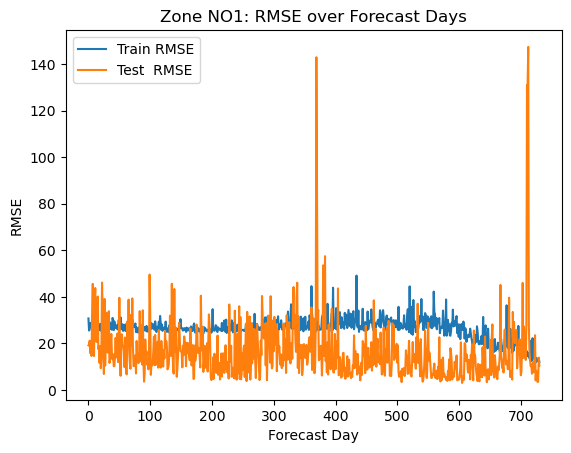

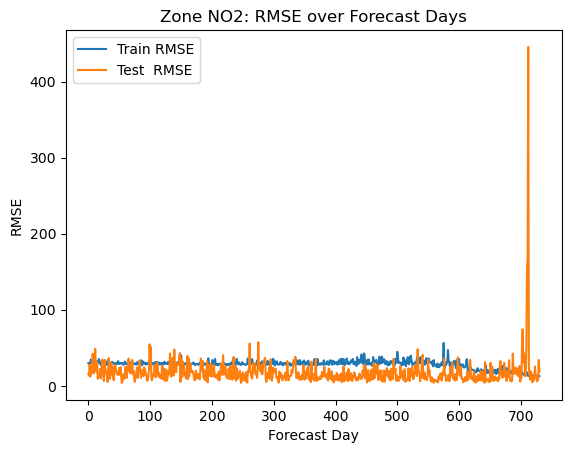

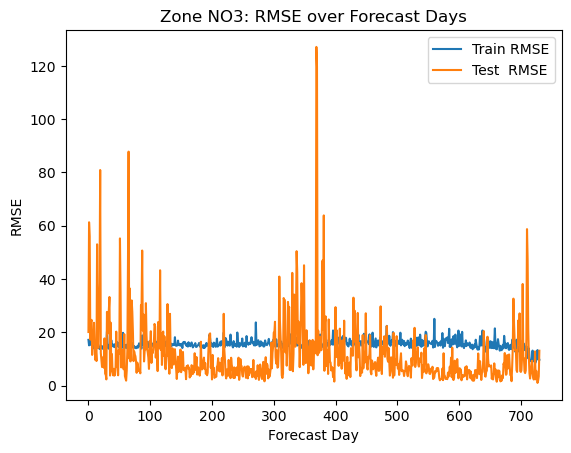

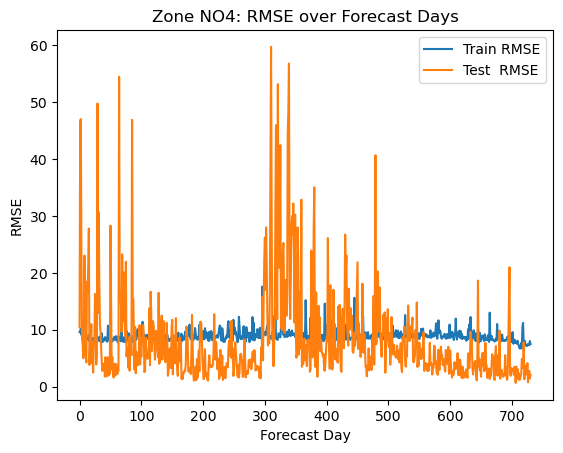

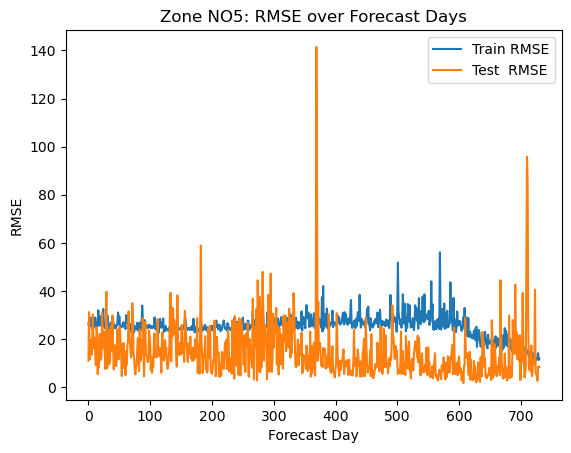

In [ ]:
# global constants to all zones
INIT_DATE_EXPERIMENTS = '2019-01-01'
INIT_TEST_DATE        = '2023-01-01'
FINAL_DATE_EXPERIMENTS= '2024-12-31'

# hyperparameters
WINDOW_DAYS   = 730                 
HIDDEN_DIM    = 128 # initial - 50                  
LEARNING_RATE = 1e-3
WEIGHT_DECAY  = 0
EPOCHS        = 60
BATCH_SIZE    = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#%cd /content/DLiE_forecast <- Collab
#repo_root  = Path.cwd().resolve() <-Collab
repo_root  = Path.cwd().parents[1]
mapcodes   = ["NO1", "NO2", "NO3", "NO4", "NO5"]
zone_data  = {}          

start_time = time.time()

for code in mapcodes:
    csv_path = repo_root / "data" / f"data_{code}.csv"
    df_raw   = pd.read_csv(csv_path, parse_dates=["time_utc"])

    data_t, train_t, train_dates, price_t = prepare_dataset_tensor_modified(
        csv_path,
        tz      = "CET",
        seed    = 42,
        test_days = (pd.Timestamp(FINAL_DATE_EXPERIMENTS)
                     - pd.Timestamp(INIT_TEST_DATE)).days + 1,
        dtype   = torch.float64,
    )

    idx = pd.DatetimeIndex(sorted(train_dates))
    start_i = idx.get_loc(pd.Timestamp(INIT_DATE_EXPERIMENTS))
    end_i   = idx.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
    data_t  = data_t[start_i:end_i+1]             
    dates_t = pd.Series(train_dates[start_i:end_i+1])

    zone_data[code] = dict(
        df        = df_raw,
        tensor    = data_t,
        dates     = dates_t,
        price_t   = price_t[start_i:end_i+1],
    )

# rolling-window MLP per zone
results_by_zone = {}

for code in mapcodes:
    print(f"\n --- Zone {code} ---")

    reg_data = build_regression_matrix(
        dat_eval = zone_data[code]["tensor"].cpu().numpy(),
        days_eval= pd.to_datetime(zone_data[code]["dates"]),
        reg_names= zone_data[code]["df"].columns[1:],   
    )
    reg_df   = reg_data["regmat"].dropna().reset_index(drop=True)
    dep_idx  = reg_data["dep_indices"]

    all_dates = pd.DatetimeIndex(sorted(zone_data[code]["dates"]\
                                        .iloc[len(zone_data[code]["dates"])
                                             - len(reg_df):]))
    test_start_row = all_dates.get_loc(pd.Timestamp(INIT_TEST_DATE))
    test_end_row   = all_dates.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
    horizon        = test_end_row - test_start_row + 1      

    preds, trues, train_rmses, test_rmses = build_mlp_rolling_forecasts(
        regmat_df   = reg_df.astype("float32"),
        dep_indices = dep_idx,
        window      = WINDOW_DAYS,
        horizon     = horizon,
        start_row   = test_start_row,
        hidden_dim  = HIDDEN_DIM,
        lr          = LEARNING_RATE,
        weight_decay= WEIGHT_DECAY,
        batch_size  = BATCH_SIZE,
        epochs      = EPOCHS,
        device      = device,
    )

    results_by_zone[code] = {
        "preds":       preds,
        "trues":       trues,
        "train_rmses": train_rmses,
        "test_rmses":   test_rmses,
    }
    
# train vs test rmse summary per region
print("Zone | Train mean | Test mean")
for code, res in results_by_zone.items():
    t = np.array(res["train_rmses"])
    s = np.array(res["test_rmses"])
    print(f"{code} | "
        f"| {t.mean():.3f} | "
        f"| {s.mean():.3f}"  )

end_time = time.time()
duration = (end_time - start_time)/60
print(f"ellapsed time: {duration:.2f} minutes")

# plot per-day series of test vs train rmse
for code, res in results_by_zone.items():
    train = res["train_rmses"]
    test  = res["test_rmses"]
    plt.figure()
    plt.plot(train, label="Train RMSE")
    plt.plot(test,  label="Test  RMSE")
    plt.title(f"Zone {code}: RMSE over Forecast Days")
    plt.xlabel("Forecast Day")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()
    


### 2.3 

Recent price

2019-2024 includes pre-/post-Ukraine shock, summer-23 reservoir recovery, the autumn-24 price slide.
A rolling window that treats every day equally assumes “one distribution fits all.
1. 2021-22 spike months dominate the MSE loss, so the network wastes capacity trying to be accurate on a pattern that is unlikely to repeat in 2025—but that same focus hurts its fit to the gentler 2024 behaviour that we actually test on. That shows up as under-fitting bias and RMSE that stays stuck in the high teens.
Solution: introduce time-decayed weighting \alpha=0.002 into training

--- Zone NO1 ---
Train mean RMSE: 26.047
Test mean RMSE: 16.117
--- Zone NO2 ---
Train mean RMSE: 28.292
Test mean RMSE: 16.987
--- Zone NO3 ---
Train mean RMSE: 15.373
Test mean RMSE: 11.204
--- Zone NO4 ---
Train mean RMSE: 9.343
Test mean RMSE: 8.169
--- Zone NO5 ---
Train mean RMSE: 25.266
Test mean RMSE: 13.598
ellapsed time: 241.04 minutes


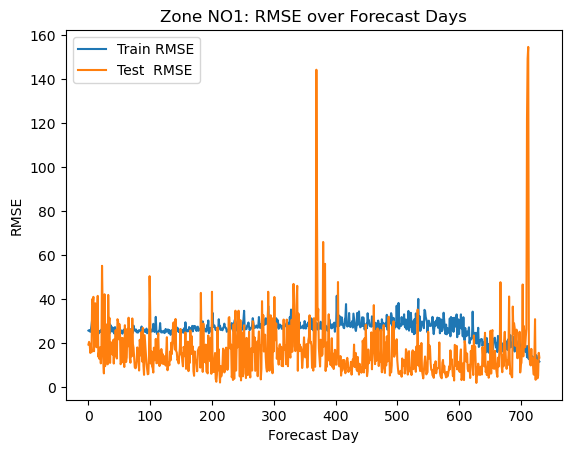

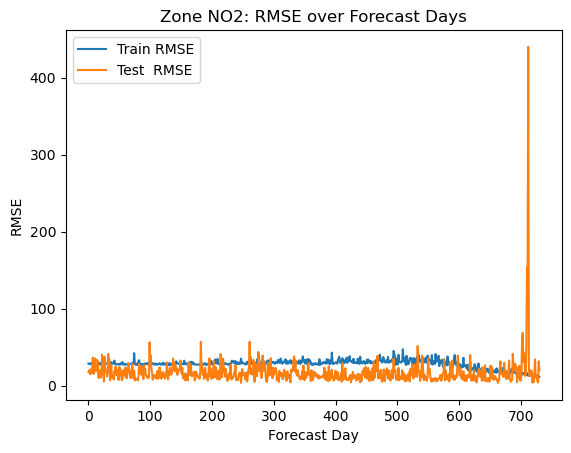

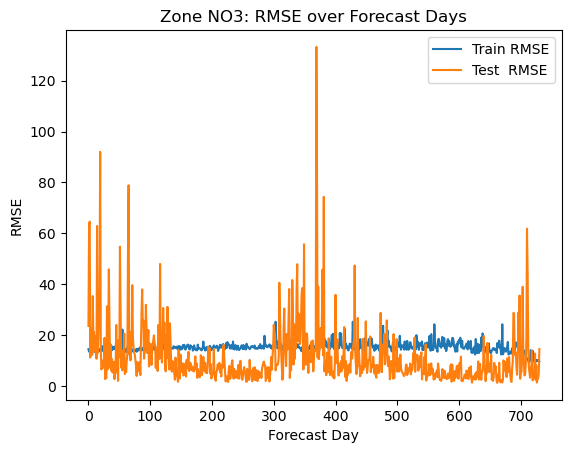

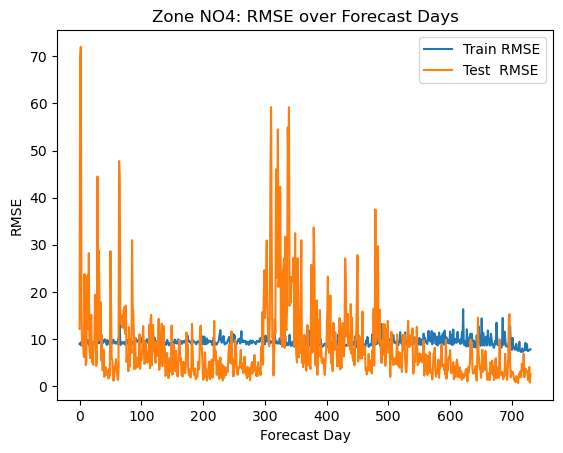

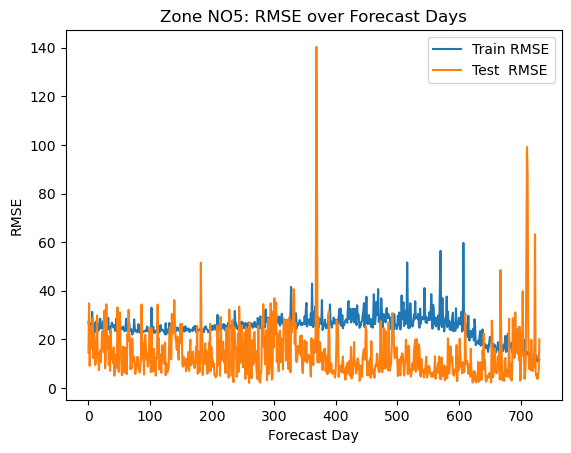

In [6]:
# global constants to all zones
INIT_DATE_EXPERIMENTS = '2019-01-01'
INIT_TEST_DATE        = '2023-01-01'
FINAL_DATE_EXPERIMENTS= '2024-12-31'

# hyperparameters
WINDOW_DAYS   = 730                 
HIDDEN_DIM    = 128 # initial - 50                  
LEARNING_RATE = 1e-3
WEIGHT_DECAY  = 0
EPOCHS        = 60
BATCH_SIZE    = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#%cd /content/DLiE_forecast <- Collab
#repo_root  = Path.cwd().resolve() <-Collab
repo_root  = Path.cwd().parents[1]
mapcodes   = ["NO1", "NO2", "NO3", "NO4", "NO5"]
zone_data  = {}          

start_time = time.time()

for code in mapcodes:
    csv_path = repo_root / "data" / f"data_{code}.csv"
    df_raw   = pd.read_csv(csv_path, parse_dates=["time_utc"])

    data_t, train_t, train_dates, price_t = prepare_dataset_tensor_modified(
        csv_path,
        tz      = "CET",
        seed    = 42,
        test_days = (pd.Timestamp(FINAL_DATE_EXPERIMENTS)
                     - pd.Timestamp(INIT_TEST_DATE)).days + 1,
        dtype   = torch.float64,
    )

    idx = pd.DatetimeIndex(sorted(train_dates))
    start_i = idx.get_loc(pd.Timestamp(INIT_DATE_EXPERIMENTS))
    end_i   = idx.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
    data_t  = data_t[start_i:end_i+1]             
    dates_t = pd.Series(train_dates[start_i:end_i+1])

    zone_data[code] = dict(
        df        = df_raw,
        tensor    = data_t,
        dates     = dates_t,
        price_t   = price_t[start_i:end_i+1],
    )

# rolling-window MLP per zone
results_by_zone = {}

for code in mapcodes:
    
    reg_data = build_regression_matrix(
        dat_eval = zone_data[code]["tensor"].cpu().numpy(),
        days_eval= pd.to_datetime(zone_data[code]["dates"]),
        reg_names= zone_data[code]["df"].columns[1:],   
    )
    reg_df   = reg_data["regmat"].dropna().reset_index(drop=True)
    dep_idx  = reg_data["dep_indices"]

    all_dates = pd.DatetimeIndex(sorted(zone_data[code]["dates"]\
                                        .iloc[len(zone_data[code]["dates"])
                                             - len(reg_df):]))
    test_start_row = all_dates.get_loc(pd.Timestamp(INIT_TEST_DATE))
    test_end_row   = all_dates.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
    horizon        = test_end_row - test_start_row + 1      

    preds, trues, train_rmses, test_rmses = build_mlp_rolling_forecasts_weighted_loss(
        regmat_df   = reg_df.astype("float32"),
        dep_indices = dep_idx,
        window      = WINDOW_DAYS,
        horizon     = horizon,
        start_row   = test_start_row,
        hidden_dim  = HIDDEN_DIM,
        lr          = LEARNING_RATE,
        weight_decay= WEIGHT_DECAY,
        batch_size  = BATCH_SIZE,
        epochs      = EPOCHS,
        device      = device,
    )

    results_by_zone[code] = {
        "preds":       preds,
        "trues":       trues,
        "train_rmses": train_rmses,
        "test_rmses":   test_rmses,
    }
  
    # train vs test rmse summary per region
    t = np.array(train_rmses)
    s = np.array(test_rmses)
    print(f"--- Zone {code} ---")
    print(f"Train mean RMSE: {t.mean():.3f}")
    print(f"Test mean RMSE: {s.mean():.3f}")

end_time = time.time()
duration = (end_time - start_time)/60
print(f"ellapsed time: {duration:.2f} minutes")

# plot per-day series of test vs train rmse
for code, res in results_by_zone.items():
    train = res["train_rmses"]
    test  = res["test_rmses"]
    plt.figure()
    plt.plot(train, label="Train RMSE")
    plt.plot(test,  label="Test  RMSE")
    plt.title(f"Zone {code}: RMSE over Forecast Days")
    plt.xlabel("Forecast Day")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()
    


In [ ]:
'''--- Zone NO1 ---
Train mean RMSE: 26.047
Test mean RMSE: 16.117
--- Zone NO2 ---
Train mean RMSE: 28.292
Test mean RMSE: 16.987
--- Zone NO3 ---
Train mean RMSE: 15.373
Test mean RMSE: 11.204
--- Zone NO4 ---
Train mean RMSE: 9.343
Test mean RMSE: 8.169
--- Zone NO5 ---
Train mean RMSE: 25.266
Test mean RMSE: 13.598
ellapsed time: 241.04 minutes'''

In [ ]:
# #------------------------------
# # Try this only in Collab:
# #------------------------------

# # build one big training DataLoader spanning entire training window
# full_loader = DataLoader(
#     TensorDataset(
#         regmat[: train_end],
#         dep_var[: train_end]
#     ),
#     batch_size=batch_size,
#     shuffle=True,
#     pin_memory=True,
#     num_workers=4,
# )

# # instantiate & train ONE model
# model = DeepMLP(...).to(device)
# opt   = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# loss_fn = nn.MSELoss()

# for epoch in range(epochs):
#     model.train()
#     for xb, yb in full_loader:
#         opt.zero_grad()
#         loss_fn(model(xb), yb).backward()
#         opt.step()

# # roll forward window and predict all horizon in one go
# model.eval()
# with torch.no_grad():
#     preds = []
#     for n in range(horizon):
#         idx = test_start + n
#         mean_x = regmat[idx-window:idx].mean(0, keepdim=True)
#         std_x  = regmat[idx-window:idx].std(0, keepdim=True).clamp_min(1)
#         x_test = ((regmat[idx:idx+1] - mean_x) / std_x)
#         pred_std = model(x_test)
#         mean_y = dep_var[idx-window:idx].mean(0, keepdim=True)
#         std_y  = dep_var[idx-window:idx].std(0, keepdim=True).clamp_min(1)
#         preds.append(pred_std * std_y + mean_y)
#     preds = torch.cat(preds, dim=0)


In [9]:
alpha = 0.002    
w = torch.exp(-alpha * torch.arange(WINDOW_DAYS-1,-1,-1,device=device))
w

tensor([0.2327, 0.2332, 0.2336, 0.2341, 0.2346, 0.2350, 0.2355, 0.2360, 0.2365,
        0.2369, 0.2374, 0.2379, 0.2384, 0.2388, 0.2393, 0.2398, 0.2403, 0.2407,
        0.2412, 0.2417, 0.2422, 0.2427, 0.2432, 0.2437, 0.2441, 0.2446, 0.2451,
        0.2456, 0.2461, 0.2466, 0.2471, 0.2476, 0.2481, 0.2486, 0.2491, 0.2496,
        0.2501, 0.2506, 0.2511, 0.2516, 0.2521, 0.2526, 0.2531, 0.2536, 0.2541,
        0.2546, 0.2551, 0.2556, 0.2561, 0.2567, 0.2572, 0.2577, 0.2582, 0.2587,
        0.2592, 0.2598, 0.2603, 0.2608, 0.2613, 0.2618, 0.2624, 0.2629, 0.2634,
        0.2639, 0.2645, 0.2650, 0.2655, 0.2661, 0.2666, 0.2671, 0.2677, 0.2682,
        0.2687, 0.2693, 0.2698, 0.2704, 0.2709, 0.2714, 0.2720, 0.2725, 0.2731,
        0.2736, 0.2742, 0.2747, 0.2753, 0.2758, 0.2764, 0.2769, 0.2775, 0.2780,
        0.2786, 0.2792, 0.2797, 0.2803, 0.2808, 0.2814, 0.2820, 0.2825, 0.2831,
        0.2837, 0.2842, 0.2848, 0.2854, 0.2859, 0.2865, 0.2871, 0.2877, 0.2882,
        0.2888, 0.2894, 0.2900, 0.2905, 